# Multi-Layer Perceptron Neural Network for Infant Mortality Classification

Note:

- Death cases: infant_mortality == 1
- Survived cases: infant_mortality == 0

# Importing data

In [ ]:
import pandas as pd
import numpy as np
df_train = pd.read_csv('https://media.githubusercontent.com/media/leahhkim/final_project_analyticsII/refs/heads/main/Data/nvss_train.csv', low_memory=False)
df_val = pd.read_csv('https://media.githubusercontent.com/media/leahhkim/final_project_analyticsII/refs/heads/main/Data/nvss_val.csv', low_memory=False)

df_train.head()

,mager14,mar,meduc,mbrace,umhisp,lbo,tbo,precare_rec,previs_rec,wtgain_rec,...,ca_menin,ca_heart,ca_ompha,ca_gastro,ca_limb,ca_cleftlp,ca_cleft,ca_downs,ca_chrom,infant_death
0,10,2,3.0,2.0,0,3,3,1.0,8,4,...,0,0,0,0,0,0,0,1,1,0
1,10,1,7.0,2.0,0,2,2,1.0,8,4,...,0,0,0,0,0,0,0,1,1,0
2,11,1,3.0,1.0,0,4,7,1.0,8,3,...,0,0,0,0,0,0,0,1,1,0
3,8,2,3.0,2.0,0,2,2,3.0,3,4,...,0,0,0,0,0,0,0,1,1,0
4,11,1,3.0,1.0,1,2,3,1.0,5,4,...,0,0,0,0,0,0,0,1,1,0


### Building Features and creating tensors

In [ ]:
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

target_col = "infant_death"

# Drop the target column from the feature dataset
X_train = df_train.drop(columns=[target_col]).values.astype("float32")
y_train = df_train[target_col].values.astype("float32")

X_val = df_val.drop(columns=[target_col]).values.astype("float32")
y_val = df_val[target_col].values.astype("float32")

print("X_train shape:", X_train.shape)

# how many deaths occur in the dataset
print("Positive death rate in train set:", y_train.mean())

# standardization of all three datasets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)


# use GPU to accelerate training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# converting to tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)

X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.float32).to(device)

batch_size = 1024

# creating data loaders for each dataset
train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t,   y_val_t)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)


X_train shape: (2138649, 38)
Positive death rate in train set: 0.0058616446
Using device: cuda:0


The positive death rate tells us that only 0.6% of the cases in the training set has an outcome of death as the target variable. This meant that we need to apply more weight to the positive case (the death case) in our neural network training to ensure that the network does not overfit negative cases and ignore positive cases.

### Examining test and validation case positive weight

In [ ]:
print("Positive death rate in validation set:", y_val.mean())

Positive death rate in test set: 0.005862104
Positive death rate in validation set: 0.005862104


### Creating the model

In [4]:
import torch.nn as nn
import torch.optim as optim

# defining a multi-layer perceptron model for binary classification
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            # first hidden layer
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64), # normalize the 64 activations to stabilize training
            nn.Dropout(0.2), # randomly drop 20% of neurons to regularize model and reduce overfitting

            # second hidden layer
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),

            # third hidden layer
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Dropout(0.2),

            # output layer
            nn.Linear(16, 1)
        )

    # defining the forward propagation function
    def forward(self, x):
        return self.net(x).squeeze(1)  # shape (batch,)

# retrieve input features from training tensor
input_dim = X_train_t.shape[1]
# create an instance of the model in GPU
model = MLP(input_dim).to(device)
print(model)


MLP(
  (net): Sequential(
    (0): Linear(in_features=38, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=16, out_features=1, bias=True)
  )
)


# Defining the training strategy
- implementing validation set to evaluate training loss during the training process
- implementing an early stopping mechanism to ensure that the model does not overfit and train on endlessly
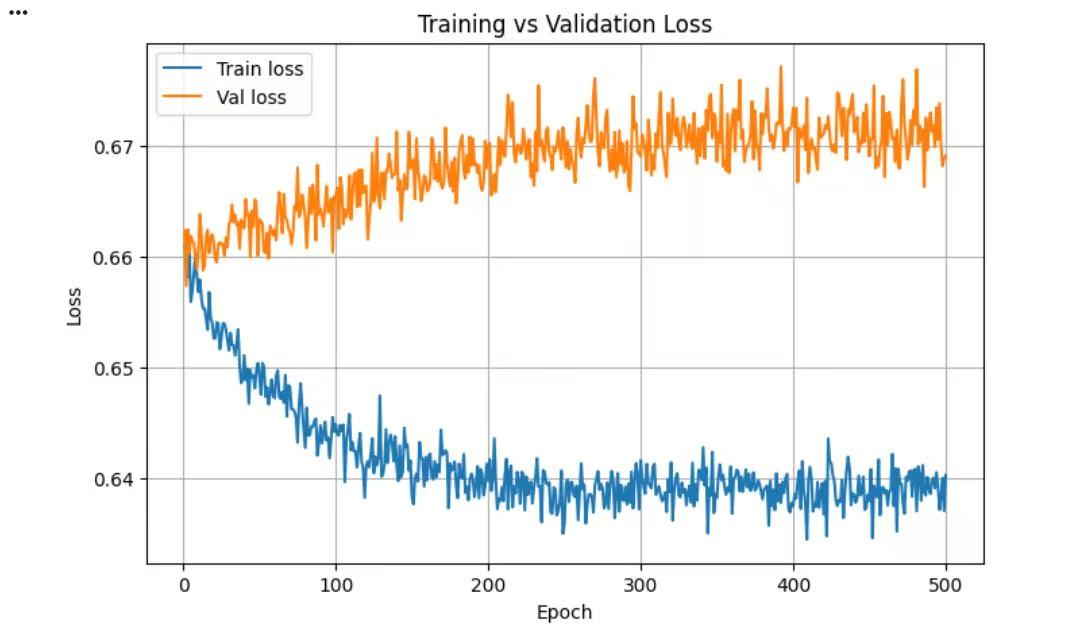

- Optimize the model by completing a grid search over a list of learning rates


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# creating an optimized neural network model via performing simple grid search over learning rates
#

def train_one_lr(lr_value):
    # build a new model for each input learning rate
    input_dim = X_train_t.shape[1]
    model = MLP(input_dim).to(device)

    # defining a positive class weight to add more weight to death cases
    # infant_death == 1
    n_pos = y_train.sum()
    n_neg = len(y_train) - n_pos
    pos_weight_value = n_neg / n_pos
    pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32).to(device)

    # defining the loss function for binary classification, applying extra weight on positive class
    # as positive classes (death cases) are rare in the data set
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # using adam optimizer with the given learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr_value)

    # maximum train for 200 epochs
    num_epochs = 200
    best_val_loss = float("inf")
    best_state_dict = None

    # parameters for early stopping mechanisms
    wait_epoch = 60
    # wait_epoch = 60
    no_improve = 0

    train_losses = []
    val_losses = []

    # train and document train and validation losses for each epoch
    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss_sum = 0.0

        # defining a one full pass over the training data
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            # add up total loss for every training sample
            train_loss_sum += loss.item() * xb.size(0)

        # calculate average training loss across all training samples
        train_loss = train_loss_sum / len(train_loader.dataset)

        # evaluate the validation set
        model.eval()
        with torch.no_grad():
            val_logits = model(X_val_t.to(device))
            val_loss = criterion(val_logits, y_val_t.to(device)).item()

        # save training and validation loss
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # check if this is hte best validation loss so far with a small tolerance
        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1

        # print every 10 epochs (and the first epoch)
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:03d} | lr={lr_value:.1e} | train={train_loss:.4f} | val={val_loss:.4f} | no_improve={no_improve}")

        # stop the training early if validation loss does not get improved over 30 epochs
        if no_improve >= wait_epoch:
            print(f"Early stopping for lr={lr_value:.1e} at epoch {epoch}")
            break
    # return best validation loss, best model parameters, and learning rate used
    return best_val_loss, best_state_dict, lr_value

# set of learning rates to test on
#lr_list = [5e-4, 1e-3, 1e-4]
lr_list = [1e-4, 3e-4, 5e-4, 1e-3, 3e-3]
results = []

# train a separate model for each learning rate and record how well it did
for lr in lr_list:
    best_loss, best_state, lr_used = train_one_lr(lr)
    results.append((best_loss, lr_used, best_state))

# pick best learning rate that had the lowest validation lost
results.sort(key=lambda x: x[0])
best_val_loss, best_lr, best_state_dict = results[0]

print("\nbest learning rate result")
print(f"Best lr={best_lr:.1e} with val_loss={best_val_loss:.4f}")

# load best model into a fresh instance for final use
model = MLP(X_train_t.shape[1]).to(device)
model.load_state_dict(best_state_dict)
torch.save(best_state_dict, "best_mlp_infant_mortality.pt")
print("Saved best model to best_mlp_infant_mortality.pt")


Epoch 001 | lr=1.0e-04 | train=0.8993 | val=0.7502 | no_improve=0
Epoch 010 | lr=1.0e-04 | train=0.6814 | val=0.6693 | no_improve=0
Epoch 020 | lr=1.0e-04 | train=0.6666 | val=0.6625 | no_improve=1
Epoch 030 | lr=1.0e-04 | train=0.6601 | val=0.6612 | no_improve=4
Epoch 040 | lr=1.0e-04 | train=0.6565 | val=0.6592 | no_improve=0
Epoch 050 | lr=1.0e-04 | train=0.6536 | val=0.6596 | no_improve=10
Epoch 060 | lr=1.0e-04 | train=0.6501 | val=0.6605 | no_improve=1
Epoch 070 | lr=1.0e-04 | train=0.6482 | val=0.6600 | no_improve=11
Epoch 080 | lr=1.0e-04 | train=0.6464 | val=0.6612 | no_improve=21
Epoch 090 | lr=1.0e-04 | train=0.6419 | val=0.6617 | no_improve=31
Epoch 100 | lr=1.0e-04 | train=0.6398 | val=0.6631 | no_improve=41
Epoch 110 | lr=1.0e-04 | train=0.6387 | val=0.6653 | no_improve=51
Early stopping for lr=1.0e-04 at epoch 119
Epoch 001 | lr=3.0e-04 | train=0.8329 | val=0.6863 | no_improve=0
Epoch 010 | lr=3.0e-04 | train=0.6670 | val=0.6624 | no_improve=1
Epoch 020 | lr=3.0e-04 | tr

### Computing evaluation metrics
- accuracy score
- positive case recall score
- roc_auc
- average precision score

In [8]:
from sklearn.metrics import roc_auc_score, average_precision_score

# Put the model in evaluation mode (turns off dropout, etc.)
model.eval()

# Turning off gradient tracking for model inference
with torch.no_grad():
    # Get raw model scores (logits) for the validation set
    logits_val = model(X_val_t)
    # Convert logits to probabilities between 0 and 1
    probs_val = torch.sigmoid(logits_val)
    # Turn probabilities into hard predictions: 1 if >= 0.5, else 0
    preds_val = (probs_val >= 0.5).float()

# Move tensors back to CPU and convert to NumPy arrays for sklearn metrics
y_val_result = y_val_t.cpu().numpy()
probs_val_result = probs_val.cpu().numpy()
preds_val_result = preds_val.cpu().numpy()

# Overall validation accuracy: fraction of all validation cases the model got right
val_acc = (preds_val_result == y_val_result).mean()

# For babies who actually died (label 1), fraction correctly predicted as 1
val_recall_pos = (
    (preds_val_result[y_val_result == 1] == 1).mean()
    if (y_val_result == 1).sum() > 0
    else float("nan")
)

# ROC-AUC: how often the model gives higher scores to deaths than to survivals
val_auc = roc_auc_score(y_val_result, probs_val_result)

# PR-AUC: when we sort by risk score, how well the model concentrates real deaths near the top
val_ap  = average_precision_score(y_val_result, probs_val_result)

print("Validation accuracy:", val_acc)
print("Validation accuracy for infant_death=1:", val_recall_pos)
print("Validation ROC-AUC:", val_auc)
print("Validation PR-AUC:", val_ap)


Validation accuracy: 0.9186978526660718
Validation accuracy for infant_death=1: 0.7882268485283561
Validation ROC-AUC: 0.921360526307957
Validation PR-AUC: 0.4882039138030979


According to the current results, we could see that the model:
- predicts validation cases with decent accuracy with 91% accuracy, meaning that the model correctly classified about 91% of the validation cases. However, this could be skewed due to how the dataset itself contains a majority of survival cases of infants, with only 0.6% of the cases are actual death cases, hence it is naturally easy for the model to classify these cases at a high
- predicts well among the test cases where the baby actually died, with a 79% accuracy.
- allocates an apprioriate high risk score to babies who died compared to cases where the baby survived in 92% of the time
- appropriately sorts high risk baby cases at the top with low risk baby cases at the bottom (those who survived), rather than randomly sorting those cases with survivors. The accuracy level is about 49%, which is relatively higher than expected considering we only have 0.6% of the cases that are death cases.